# Reprojecting to EPSG:4326

The same place on earth can be described in different ways depending on your coordiante reference system and map projection.  Sometimes you have a location description in one system but you would like to convert it to another.  This process is called reprojecting and it is the subject of this noteook.

In [1]:
# All imports for this notebook
import rasterio
from shapely.geometry import box
import rasterio.plot as rplot
import os

## Vectors and Rasters

The two main sections of this notebook are:
1. Reprojecting Vector Objects
2. Reprojecting Raster Objects

To recap the difference, vector objects are a single point or a series of points that make a shape, whereas raster data is the pixel structure discussed in other notebooks.

In [2]:
from IPython.display import Image

In [3]:
Image(url= "https://www.firenorth.org.au/nafi3/images/help/image036.png", width=330)

Working with vector data like points or a bounding box requires a new library - `shapley`.  So now our two main spatial libraries are:
* `shapely` - vector data, such as points and polygons
* `rasterio` - raster data, such as satellite imagery

## Reprojecting vector objects

### The Reproject Function

This code is a custom function that we are defining and calling `reproject_vector`.  It uses some less-common functionality so I am not going to dig into the inside of this function.  For now just know that once you run this cell you can call `reproject_vector()` as a function for the rest of the notebook.

In [4]:
import pyproj
from shapely import ops
from functools import partial

def reproject_vector(geom, from_proj=None, to_proj=None):
    """
    Recommended function provided by shapely for projection transformations
    :param geom: shapely geometry object
    :param to_proj: source projection string
    :param from_proj: destination projection string
    :return: reprojected shapely geometry
    """
    tfm = partial(pyproj.transform, pyproj.Proj(from_proj), pyproj.Proj(to_proj))
    return ops.transform(tfm, geom)

## Reprojecting a Point or Bounding Box

**Step 1 - Define the shape we want to reproject**

Let's pick a shape to reproject.

For these examples I am going to reproject three objects:
1. the bounding box of the raster, which is a polygon
2. the geometric center of our raster (the **centroid**), which is a point
3. a random point I define myself

In [5]:
import rasterio
from shapely.geometry import box

In [6]:
filepath_rad = '../input_data/f100520t01p00r08rdn_b/f100520t01p00r08rdn_b_sc01_ort_img'
with rasterio.open(filepath_rad, 'r') as src:
    bbox = src.bounds

In [7]:
utm_bbox = box(*bbox)
utm_centroid = utm_bbox.centroid
print('Centroid: ', utm_centroid)
print('Bounding box: ', utm_bbox)

Centroid:  POINT (490183.9700000001 3357375.75)
Bounding box:  POLYGON ((504582.17 3350578.5, 504582.17 3364173, 475785.77 3364173, 475785.77 3350578.5, 504582.17 3350578.5))


The object that is returned from from the `.centroid` method is a shapley `Point` object.  The object produced in with the `box()` method is a `Polygon`.

Alternatively, we could use some other random point, but we will have to create that `Point` object ourselves.

In [8]:
from shapely.geometry import Point

In [9]:
# utm_point = Point(500000, 0)
utm_point = Point(475785.77, 3350578.5)

Notice that I chose a point which was at the center easting and sits on the equator (assuming a northern hemisphere grid).  We should be able to check that in our output.

**Step 2 - Define the input and output coordinate reference systems**

The source crs we can pull directly from the raster.  For the output since we want latitude and longitude as a result we can manually specify `EPSG:4326`.

In [10]:
with rasterio.open(filepath_rad, 'r') as src:
    src_crs = src.crs
print('source crs is: ', src_crs)

source crs is:  EPSG:32616


In [11]:
dst_crs = 'EPSG:4326'
print('destination crs is: ', dst_crs)

destination crs is:  EPSG:4326


**Step 3 - Input the shape into our reproject function**

Once our point is defined we can input it into our reproject function.

In [12]:
wgs84_point = reproject_vector(utm_point, from_proj=src_crs, to_proj=dst_crs)
wgs84_centroid = reproject_vector(utm_centroid, from_proj=src_crs, to_proj=dst_crs)
wgs84_bbox = reproject_vector(utm_bbox, from_proj=src_crs, to_proj=dst_crs)

In [13]:
print('random point in 4326: ', wgs84_point)
print('centroid in 4326: ', wgs84_centroid)
print('bounding box in 4326: ', wgs84_bbox)

random point in 4326:  POINT (30.28667237000204 -87.25178719598659)
centroid in 4326:  POINT (30.34821418934487 -87.10213411955947)
bounding box in 4326:  POLYGON ((30.28690584349906 -86.95235296598685, 30.40958435532548 -86.9522934966751, 30.40934973837654 -87.25210145321883, 30.28667237000204 -87.25178719598659, 30.28690584349906 -86.95235296598685))


# Reprojecting a raster

### Defining the Function

Reprojecting a raster is a bit more complicated than reprojecting vectors.  If you are interested in the nuts and bolts certainly take the time to walk through this function step by step.  Otherwise I would treat this function like the vector `reproject_vector` function, as a cell of code where you supply the inputs.

The code I have below is just a function of the code supplied in the [rasterio docs](https://rasterio.readthedocs.io/en/latest/topics/reproject.html).

In [14]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Raster reproject function
def reproject_raster(input_filepath, output_filepath, dst_crs):
    """
    Recommended function provided by rasterio for raster transformations
    :param input_filepath: the absolute or relative filepath of the raster to reproject
    :param output_filepath: where to save the reprojected file
    :param dst_crs: the crs to which to reproject the raster
    """
    with rasterio.open(input_filepath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_filepath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

### Running the Function

In [15]:
# Make the output directory if it does not exist yet
import os
if not os.path.exists('../output_data'):
    os.makedirs('../output_data')

In [16]:
# Define our inputs
filepath_rad = '../input_data/f100520t01p00r08rdn_b/f100520t01p00r08rdn_b_sc01_ort_img'
output_path = '../output_data/ort_img_4326'

# Run the function
reproject_raster(filepath_rad, output_path, 'EPSG:4326')

If we now open up our new raster we can see the output file.  Notice how the bounds changed to use our new coordinate system!

In [17]:
import rasterio.plot as rplot

{'driver': 'ENVI', 'dtype': 'int16', 'nodata': None, 'width': 1724, 'height': 707, 'count': 224, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.000173874084932819, -0.0, -87.2521014532188,
       -0.0, -0.000173874084932819, 30.4095930403477)}


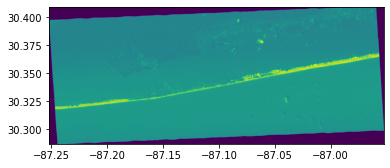

In [18]:
with rasterio.open(output_path, 'r') as src:
    print(src.meta)
    rplot.show(src)

Also notice in the metadata that the height and width have changed from the original source data.  This is because when reprojecting raster data we actually change it a little.